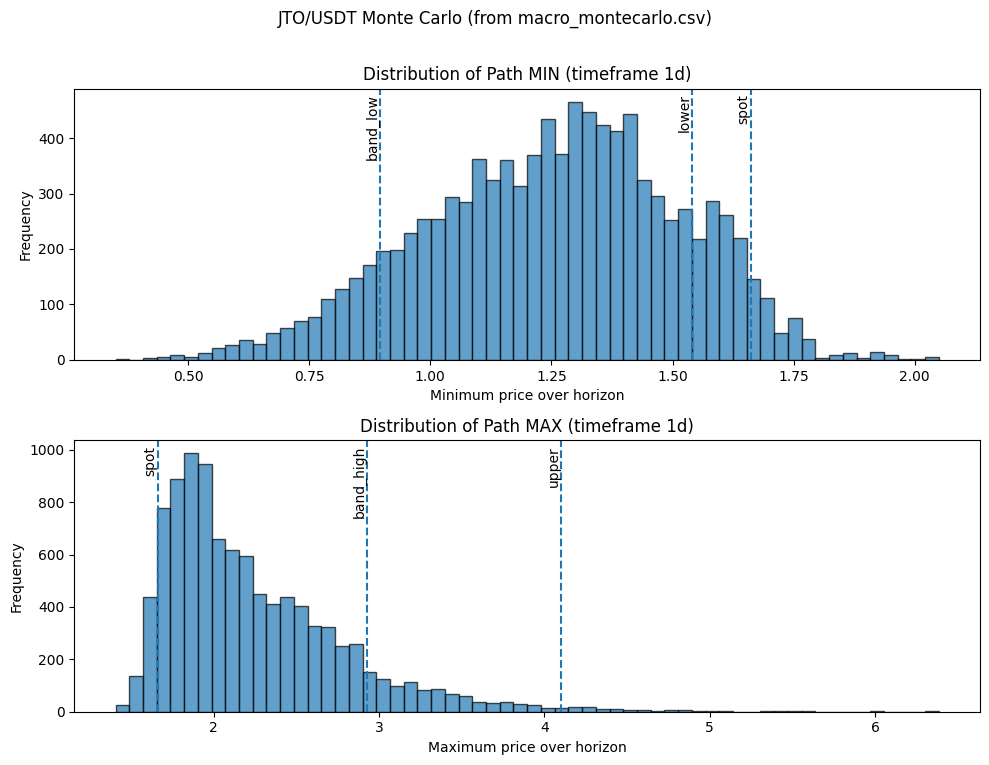

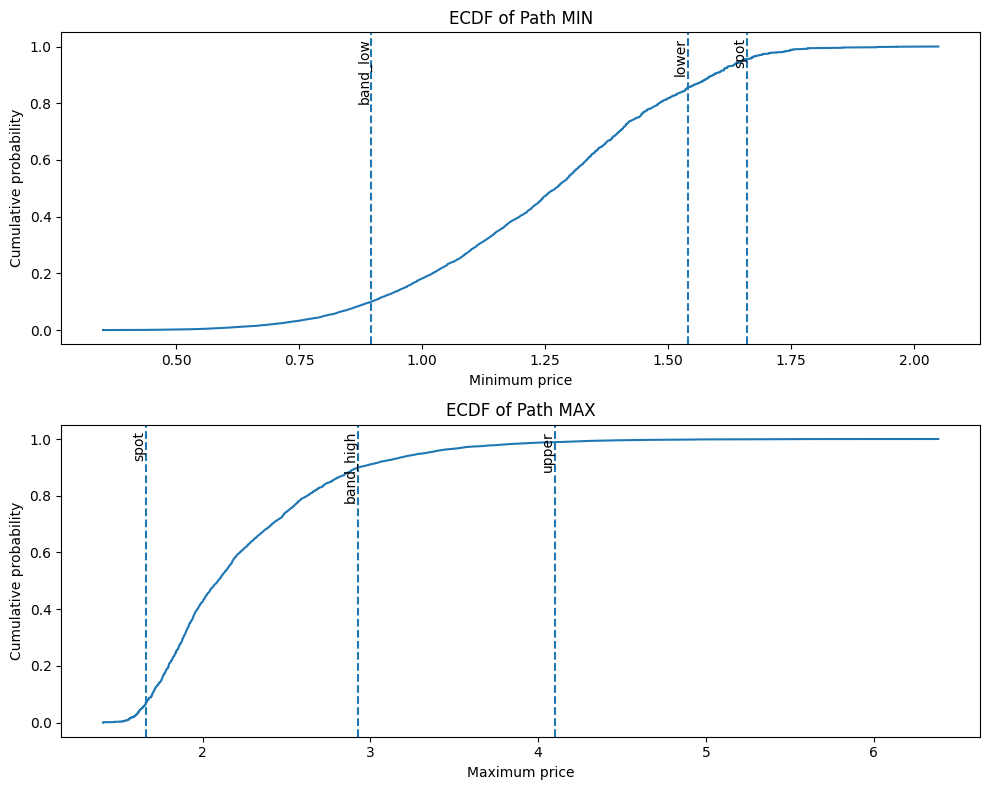

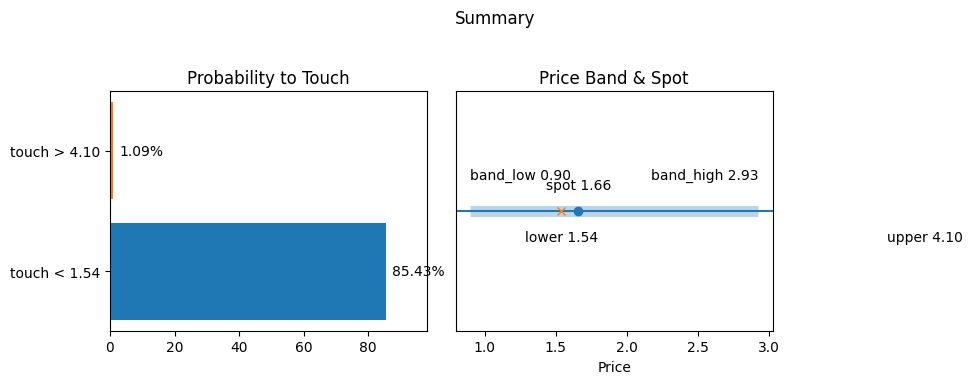

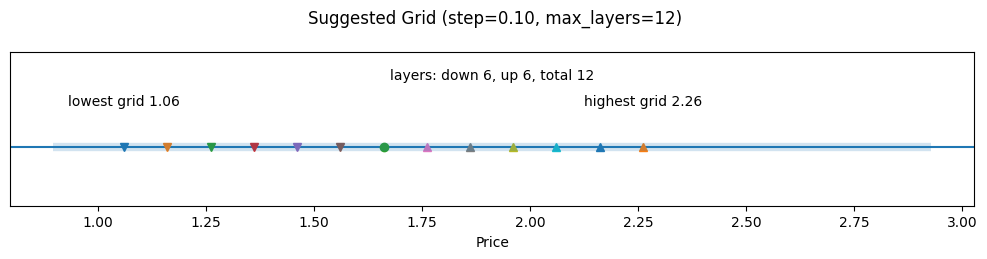

In [1]:

"""
Visualize Macro Monte Carlo (no args, just run → show plots)
"""

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Utils ----------
def ecdf(arr: np.ndarray):
    x = np.sort(arr)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

def vline(ax, x, label=None, linestyle="--", linewidth=1.5):
    if x is None or np.isnan(x): return
    ax.axvline(x, linestyle=linestyle, linewidth=linewidth)
    if label:
        ymin, ymax = ax.get_ylim()
        ax.text(x, ymax*0.98, str(label), rotation=90, va="top", ha="right")

def suggest_grid(spot: float, band_low: float, band_high: float, step: float, max_layers: int):
    if any(np.isnan(v) for v in [spot, band_low, band_high, step]) or max_layers is None:
        return [], []
    dn_levels, up_levels = [], []
    p = spot - step
    while p >= band_low - 1e-12:
        dn_levels.append(round(p, 4)); p -= step
    p = spot + step
    while p <= band_high + 1e-12:
        up_levels.append(round(p, 4)); p += step
    keep_dn, keep_up = len(dn_levels), len(up_levels)
    while (keep_dn + keep_up) > max_layers and (keep_dn > 0 or keep_up > 0):
        if keep_dn >= keep_up and keep_dn > 0: keep_dn -= 1
        elif keep_up > 0: keep_up -= 1
        else: break
    return dn_levels[:keep_dn][::-1], up_levels[:keep_up]

def read_csv_loose():
    candidates = [
        "macro_montecarlo.csv", "macro_montecarlo*.csv",
        "macro_mc*.csv", "*macro*monte*carlo*.csv",
        "marco_montecalro.csv", "*marco*montecalro*.csv", # รองรับสะกดผิด
    ]
    for pat in candidates:
        for path in glob.glob(pat):
            try:
                df = pd.read_csv(path); return df, path
            except Exception:
                pass
    raise FileNotFoundError("ไม่พบไฟล์ CSV (วาง 'macro_montecarlo.csv' ไว้โฟลเดอร์นี้)")

# ---------- Robust x-limits ----------
def choose_xlim(mins: np.ndarray, maxs: np.ndarray,
                band_low: float, band_high: float,
                spot: float, step_hint: float = 0.10):
    if not np.isnan(band_low) and not np.isnan(band_high) and band_high > band_low:
        width = band_high - band_low
        margin = max(step_hint, 0.02 * width)
        lo, hi = band_low - margin, band_high + margin
    else:
        lo_candidates = [np.nanpercentile(mins, 1) if len(mins) else np.nan,
                         np.nanpercentile(maxs, 1) if len(maxs) else np.nan]
        hi_candidates = [np.nanpercentile(mins, 99) if len(mins) else np.nan,
                         np.nanpercentile(maxs, 99) if len(maxs) else np.nan]
        lo = np.nanmin(lo_candidates); hi = np.nanmax(hi_candidates)
        if np.isnan(lo) or np.isnan(hi) or hi <= lo:
            lo, hi = 0.0, 1.0
    lo = max(0.0, lo)
    if not np.isnan(spot):
        lo = min(lo, spot * 0.98)
        hi = max(hi, spot * 1.02)
    if hi - lo < max(step_hint * 4, 1e-6):
        center = (hi + lo) / 2
        half = max(step_hint * 2, 0.5)
        lo, hi = max(0.0, center - half), center + half
    return lo, hi

# ---------- Main ----------
def main():
    df, path = read_csv_loose()
    if "path_id" not in df.columns:
        raise RuntimeError("CSV ต้องมีคอลัมน์ path_id, min_price, max_price และแถวสรุป (path_id เป็น NaN)")

    df_paths = df[df["path_id"].notna()].copy()
    df_summ  = df[df["path_id"].isna()].tail(1).copy()
    if df_summ.empty or df_paths.empty:
        raise RuntimeError("ต้องมีแถว path-level หลายแถว + แถวสรุป 1 แถว")

    S = df_summ.iloc[0]
    getf = lambda k, default=np.nan: float(S[k]) if k in df_summ.columns and pd.notna(S[k]) else default
    gets = lambda k, default="": str(S[k]) if k in df_summ.columns and pd.notna(S[k]) else default
    geti = lambda k, default=None: int(S[k]) if k in df_summ.columns and pd.notna(S[k]) else default

    symbol      = gets("symbol", "JTO/USDT")
    # symbol      = gets("symbol", "XRP/USDT")
    timeframe   = gets("timeframe", "1d")
    spot        = getf("spot")
    p_touch_low = getf("p_touch_low")
    p_touch_high= getf("p_touch_high")
    band_low    = getf("band_low")
    band_high   = getf("band_high")
    lower_level = getf("lower_level")
    upper_level = getf("upper_level")
    step_hint   = getf("grid_min_step", 0.10)
    max_layers  = geti("max_layers", 12)

    mins = df_paths["min_price"].astype(float).to_numpy()
    maxs = df_paths["max_price"].astype(float).to_numpy()

    # ============ FIGURE 1: Histograms ============
    fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    fig1.suptitle(f"{symbol} Monte Carlo (from {os.path.basename(path)})")
    ax1.hist(mins, bins=60, edgecolor="black", alpha=0.7)
    ax1.set_title(f"Distribution of Path MIN (timeframe {timeframe})")
    ax1.set_xlabel("Minimum price over horizon"); ax1.set_ylabel("Frequency")
    vline(ax1, band_low, "band_low"); vline(ax1, spot, "spot"); vline(ax1, lower_level, "lower")

    ax2.hist(maxs, bins=60, edgecolor="black", alpha=0.7)
    ax2.set_title(f"Distribution of Path MAX (timeframe {timeframe})")
    ax2.set_xlabel("Maximum price over horizon"); ax2.set_ylabel("Frequency")
    vline(ax2, band_high, "band_high"); vline(ax2, spot, "spot"); vline(ax2, upper_level, "upper")
    fig1.tight_layout(rect=[0, 0.03, 1, 0.97])

    # ============ FIGURE 2: ECDF ============
    fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 8))
    x_min, y_min = ecdf(mins); ax3.plot(x_min, y_min)
    ax3.set_title("ECDF of Path MIN"); ax3.set_xlabel("Minimum price"); ax3.set_ylabel("Cumulative probability")
    vline(ax3, band_low, "band_low"); vline(ax3, spot, "spot"); vline(ax3, lower_level, "lower")

    x_max, y_max = ecdf(maxs); ax4.plot(x_max, y_max)
    ax4.set_title("ECDF of Path MAX"); ax4.set_xlabel("Maximum price"); ax4.set_ylabel("Cumulative probability")
    vline(ax4, band_high, "band_high"); vline(ax4, spot, "spot"); vline(ax4, upper_level, "upper")
    fig2.tight_layout()

    # ============ FIGURE 3: Summary + Price Band (auto xlim + annotations) ============
    fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(10, 4))
    fig3.suptitle("Summary")

    # Prob bars
    ax5.set_title("Probability to Touch")
    ax5.barh([0], [max(0.0, p_touch_low if not np.isnan(p_touch_low) else 0.0)])
    ax5.barh([1], [max(0.0, p_touch_high if not np.isnan(p_touch_high) else 0.0)])
    ax5.set_yticks([0, 1])
    ax5.set_yticklabels([
        f"touch < {lower_level:.2f}" if not np.isnan(lower_level) else "touch < LOW",
        f"touch > {upper_level:.2f}" if not np.isnan(upper_level) else "touch > HIGH",
    ])
    xmax_prob = max(1.0, np.nanmax([p_touch_low, p_touch_high]) * 1.15 if not np.isnan(p_touch_low) or not np.isnan(p_touch_high) else 1.0)
    ax5.set_xlim(0, xmax_prob)
    for rect in ax5.patches:
        w = rect.get_width()
        ax5.text(w + xmax_prob*0.02, rect.get_y() + rect.get_height()/2, f"{w:.2f}%", va="center")

    # Price band line with robust xlim
    ax6.set_title("Price Band & Spot")
    lo, hi = choose_xlim(mins, maxs, band_low, band_high, spot, step_hint)
    ax6.hlines(1, lo, hi)
    ax6.set_xlim(lo, hi); ax6.set_ylim(0.5, 1.5); ax6.set_yticks([]); ax6.set_xlabel("Price")

    # แถบ band + ตัวเลขปลายแถบ
    if not np.isnan(band_low) and not np.isnan(band_high):
        ax6.hlines(1, band_low, band_high, linewidth=8, alpha=0.3)
        ax6.text(band_low, 1.12, f"band_low {band_low:.2f}", ha="left", va="bottom", rotation=0)
        ax6.text(band_high, 1.12, f"band_high {band_high:.2f}", ha="right", va="bottom", rotation=0)

    # จุดสำคัญ + ตัวเลข
    if not np.isnan(spot):
        ax6.plot([spot], [1], marker="o")
        ax6.text(spot, 1.08, f"spot {spot:.2f}", ha="center", va="bottom")
    if not np.isnan(lower_level):
        ax6.plot([lower_level], [1], marker="x")
        ax6.text(lower_level, 0.92, f"lower {lower_level:.2f}", ha="center", va="top")
    if not np.isnan(upper_level):
        ax6.plot([upper_level], [1], marker="x")
        ax6.text(upper_level, 0.92, f"upper {upper_level:.2f}", ha="center", va="top")

    fig3.tight_layout(rect=[0, 0.03, 1, 0.95])

    # ============ FIGURE 4: Grid (auto xlim + annotations) ============
    try:
        dn_levels, up_levels = suggest_grid(spot, band_low, band_high, step_hint, max_layers)
        fig4, ax7 = plt.subplots(figsize=(10, 2.6))
        fig4.suptitle(f"Suggested Grid (step={step_hint:.2f}, max_layers={max_layers})")
        lo_g, hi_g = choose_xlim(mins, maxs, band_low, band_high, spot, step_hint)
        ax7.hlines(1, lo_g, hi_g)
        ax7.set_xlim(lo_g, hi_g); ax7.set_ylim(0.5, 1.8); ax7.set_yticks([]); ax7.set_xlabel("Price")

        for lv in dn_levels: ax7.plot([lv], [1], marker="v")
        for lv in up_levels: ax7.plot([lv], [1], marker="^")
        if not np.isnan(spot): ax7.plot([spot], [1], marker="o")
        if not np.isnan(band_low) and not np.isnan(band_high):
            ax7.hlines(1, band_low, band_high, linewidth=6, alpha=0.2)

        # ป้ายปลายสุด + จำนวนเลเยอร์
        if dn_levels:
            ax7.text(dn_levels[0], 1.35, f"lowest grid {dn_levels[0]:.2f}", ha="center")
        if up_levels:
            ax7.text(up_levels[-1], 1.35, f"highest grid {up_levels[-1]:.2f}", ha="center")
        ax7.text((lo_g+hi_g)/2, 1.55, f"layers: down {len(dn_levels)}, up {len(up_levels)}, total {len(dn_levels)+len(up_levels)}",
                 ha="center", va="bottom")

        fig4.tight_layout()
    except Exception:
        pass

    plt.show()

if __name__ == "__main__":
    main()


In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 25.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 34.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 16.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
